## 10.3 训练自己的语义分割网络GPU版

**Daitu：2505131775@qq.com**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import glob
from time import time
import os
from skimage.io import imread
import copy
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import transforms
from torchvision.models import vgg19
from torchsummary import summary

In [23]:
## 定义计算设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 数据准备

1:数据读取

2:数据预处理,标准化和裁剪

3:预处理数据的预测标签

4:数据加载器

In [4]:
## 定义一个读取图像的函数
def read_image(root = "VOC2012/ImageSets/Segmentation/train.txt"):
    """读取指定路径下的所指定的图像文件"""
    image = np.loadtxt(root,dtype=str)
    n = len(image)
    data, label = [None]*n , [None]*n
    for i, fname in enumerate(image):
        data[i] = imread("VOC2012/JPEGImages/%s.jpg" %(fname))
        label[i] = imread("VOC2012/SegmentationClass/%s.png" %(fname))
    return data,label

In [5]:
## 读取训练数据
traindata,trainlabel = read_image(root = "VOC2012/ImageSets/Segmentation/train.txt")
# ## 读取验证数据集
# valdata,vallabel = read_image(root = "data/VOC2012/ImageSets/Segmentation/val.txt")
# len(traindata),len(valdata)

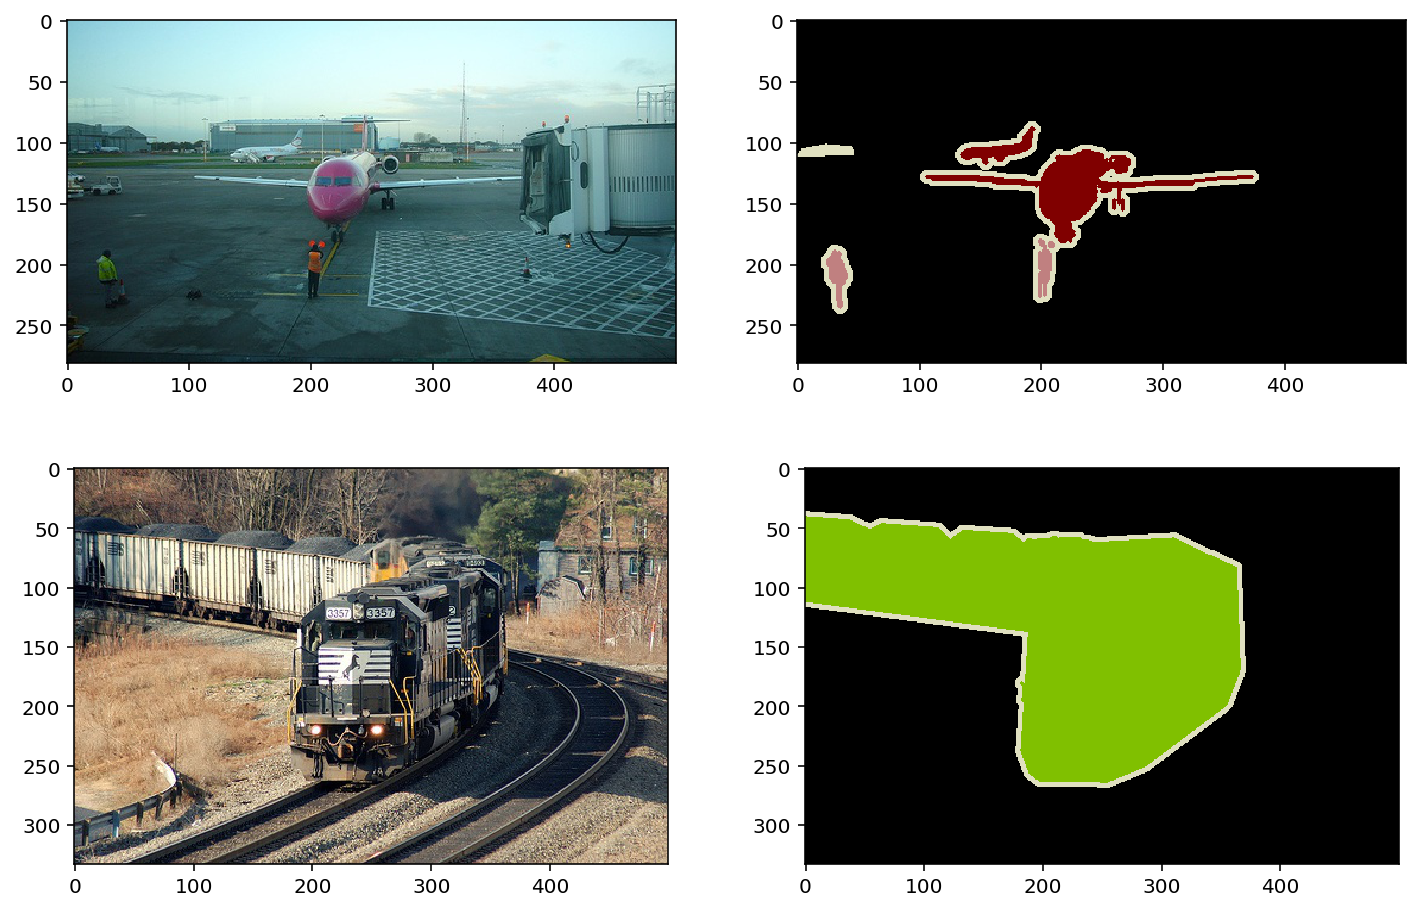

In [6]:
## 查看训练集和验证集的一些图像
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(traindata[0])
plt.subplot(2,2,2)
plt.imshow(trainlabel[0])
plt.subplot(2,2,3)
plt.imshow(traindata[10])
plt.subplot(2,2,4)
plt.imshow(trainlabel[10])
plt.show()

### 处理图像的类别标签

In [7]:
## 列出每个物体对应背景的RGB值
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
# 每个类的RGB值
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

In [8]:
## 给定一个标号图片，将像素值对应的物体找出来
def image2label(image,colormap):
    ## 将标签转化为没个像素值为1类数据
    cm2lbl = np.zeros(256**3)
    for i,cm in enumerate(colormap):
        cm2lbl[(cm[0]*256+cm[1]*256+cm[2])] = i
    ## 对一张图像准换
    image = np.array(image, dtype="int64")
    ix = (image[:,:,0]*256+image[:,:,1]*256+image[:,:,2])
    image2 = cm2lbl[ix]
    return image2

def center_crop(data, label, height, width):
    """data, label都是PIL.Image读取的图像"""
    ##使用中心裁剪（因为图像大小是一样的）
    data = transforms.CenterCrop((height, width))(data)
    label = transforms.CenterCrop((height, width))(label)
    return data, label

## 随机裁剪图像数据
def rand_crop(data,label,high,width):
    im_width,im_high = data.size
    ## 生成图像随机点的位置
    left = np.random.randint(0,im_width - width)
    top = np.random.randint(0,im_high - high)
    right = left+width
    bottom = top+high
    data = data.crop((left, top, right, bottom)) 
    label = label.crop((left, top, right, bottom)) 
    return data,label

## 单个图像的转换操作
def img_transforms(data, label, high,width,colormap):
    data, label = rand_crop(data, label, high,width)
    data_tfs = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
    data = data_tfs(data)
    label = torch.from_numpy(image2label(label,colormap))
    return data, label

## 定义一列出需要读取的数据路径的函数
def read_image_path(root = "VOC2012/ImageSets/Segmentation/train.txt"):
    """保存指定路径下的所有需要读取的图像文件路径"""
    image = np.loadtxt(root,dtype=str)
    n = len(image)
    data, label = [None]*n , [None]*n
    for i, fname in enumerate(image):
        data[i] = "VOC2012/JPEGImages/%s.jpg" %(fname)
        label[i] = "VOC2012/SegmentationClass/%s.png" %(fname)
    return data,label

In [9]:
## 最后我们定义一个 MyDataset 继承于torch.utils.data.Dataset构成我们自定的训练集
class MyDataset(Data.Dataset):
    """用于读取图像，并进行相应的裁剪等"""
    def __init__(self, data_root,high,width, imtransform,colormap):
        ## data_root:数据所对应的文件名,high,width:图像裁剪后的尺寸,
        ## imtransform:预处理操作,colormap:颜色
        self.data_root = data_root
        self.high = high
        self.width = width
        self.imtransform = imtransform
        self.colormap = colormap
        data_list, label_list = read_image_path(root=data_root)
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
        
    def _filter(self, images): # 过滤掉图片大小小于指定high,width的图片
        return [im for im in images if (Image.open(im).size[1] > high and 
                                        Image.open(im).size[0] > width)]
    
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')
        img, label = self.imtransform(img, label, self.high,
                                      self.width,self.colormap)
        return img, label
    
    def __len__(self):
        return len(self.data_list)


In [10]:
## 读取数据
high,width = 320,480
voc_train = MyDataset("VOC2012/ImageSets/Segmentation/train.txt",
                      high,width, img_transforms,colormap)
voc_val = MyDataset("VOC2012/ImageSets/Segmentation/val.txt",
                    high,width, img_transforms,colormap)
# 创建数据加载器每个batch使用4张图像
train_loader = Data.DataLoader(voc_train, batch_size=4,shuffle=True,
                               num_workers=8,pin_memory=True)
val_loader = Data.DataLoader(voc_val, batch_size=4,shuffle=True,
                             num_workers=8,pin_memory=True)

In [11]:
##  检查训练数据集的一个batch的样本的维度是否正确
for step, (b_x, b_y) in enumerate(train_loader):  
    if step > 0:
        break
## 输出训练图像的尺寸和标签的尺寸，和数据类型
print("b_x.shape:",b_x.shape)
print("b_y.shape:",b_y.shape)
print("b_x.dtype:",b_x.dtype)
print("b_y.dtype:",b_y.dtype)

b_x.shape: torch.Size([4, 3, 320, 480])
b_y.shape: torch.Size([4, 320, 480])
b_x.dtype: torch.float32
b_y.dtype: torch.float64


In [12]:
## 将标准化后的图像转化为0～1的区间
def inv_normalize_image(data):
    rgb_mean = np.array([0.485, 0.456, 0.406])
    rgb_std = np.array([0.229, 0.224, 0.225])
    data = data.astype('float32') * rgb_std + rgb_mean
    return data.clip(0,1)

## 从预测的标签转化为图像的操作
def label2image(prelabel,colormap):
    ## 预测的到的标签转化为图像,针对一个标签图
    h,w = prelabel.shape
    prelabel = prelabel.reshape(h*w,-1)
    image = np.zeros((h*w,3),dtype="int32")
    for ii in range(len(colormap)):
        index = np.where(prelabel == ii)
        image[index,:] = colormap[ii]
    return image.reshape(h,w,3)

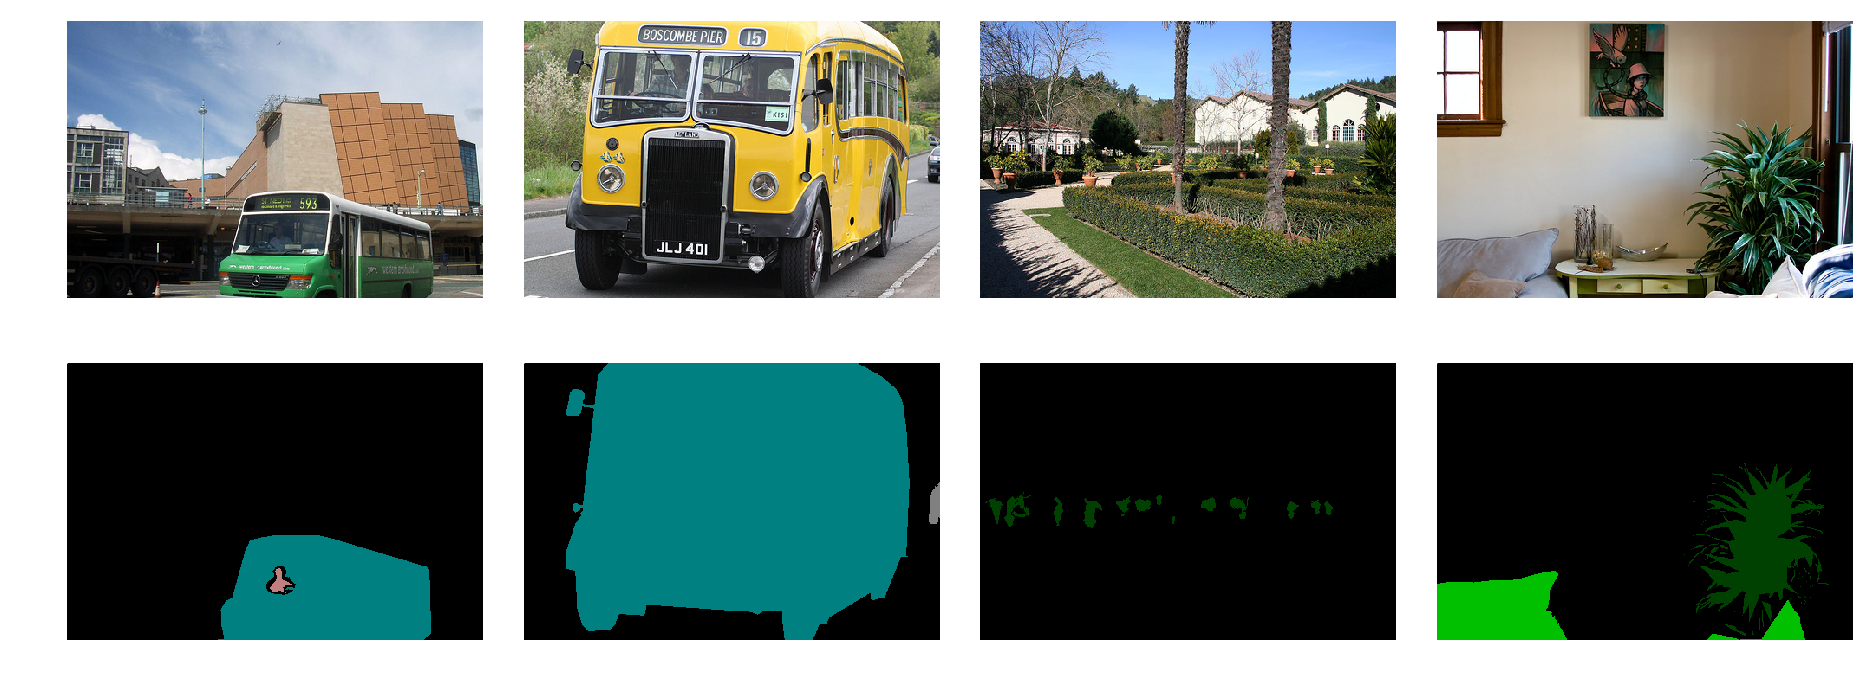

In [13]:
## 可视化一个batch的图像，检查数据预处理 是否正确
b_x_numpy = b_x.data.numpy()
b_x_numpy = b_x_numpy.transpose(0,2,3,1)
b_y_numpy = b_y.data.numpy()
plt.figure(figsize=(16,6))
for ii in range(4):
    plt.subplot(2,4,ii+1)
    plt.imshow(inv_normalize_image(b_x_numpy[ii]))
    plt.axis("off")
    plt.subplot(2,4,ii+5)
    plt.imshow(label2image(b_y_numpy[ii],colormap))
    plt.axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


In [14]:
len(b_y)

4

### 网络搭建

In [24]:
## 使用预训练好的VGG19网络作为基础网络
model_vgg19 = vgg19(pretrained=True)
## 不使用vgg19网络中的后面的AdaptiveAvgPool2d和Linear层
base_model = model_vgg19.features
summary(base_model.to(device),input_size=(3, high,width))
## vgg19的features网络通过5个MaxPool将图像尺寸缩小了32倍
## 图像尺寸缩小后分别在：MaxPool2d-5(缩小2倍) ,MaxPool2d-10 （缩小4倍）,MaxPool2d-19（缩小8倍）,
## MaxPool2d-28（缩小16倍）,MaxPool2d-37（缩小32倍）

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 480]           1,792
              ReLU-2         [-1, 64, 320, 480]               0
            Conv2d-3         [-1, 64, 320, 480]          36,928
              ReLU-4         [-1, 64, 320, 480]               0
         MaxPool2d-5         [-1, 64, 160, 240]               0
            Conv2d-6        [-1, 128, 160, 240]          73,856
              ReLU-7        [-1, 128, 160, 240]               0
            Conv2d-8        [-1, 128, 160, 240]         147,584
              ReLU-9        [-1, 128, 160, 240]               0
        MaxPool2d-10         [-1, 128, 80, 120]               0
           Conv2d-11         [-1, 256, 80, 120]         295,168
             ReLU-12         [-1, 256, 80, 120]               0
           Conv2d-13         [-1, 256, 80, 120]         590,080
             ReLU-14         [-1, 256, 

将网络中间的输出联合起来进行转置卷积，这样能够依赖更多的信息，所以可以得到更好的结果
fcn-32s 就是直接将最后的结果通过转置卷积扩大 32 倍进行输出，而 fcn-16x 就是联合前面一次的结果进行 16 倍的输出，
fcn-8x 就是联合前面两次的结果进行 8 倍的输出，
以 fcn-8x 举例，就是先将最后的结果通过转置卷积扩大 2 倍，然后和 pool4 的结果相加，然后在通过转置卷积扩大 2 倍，然后和 pool3 的结果相加，最后通过转置卷积扩大 8 倍得到和输入形状一样大的结果。

In [16]:
## 定义FCN语义分割网络
class FCN8s(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # num_classes:训练数据的类别
        self.num_classes = num_classes
        model_vgg19 = vgg19(pretrained=True)
        ## 不使用vgg9网络中的后面的AdaptiveAvgPool2d和Linear层
        self.base_model = model_vgg19.features
        ## 定义几个需要的层操作，并且使用转置卷积将特征映射进行升维
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2,
                                          padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, 1, 1, 1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1, 1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1, 1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1, 1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)
    
        ## vgg19中MaxPool2d所在的层
        self.layers = {"4": "maxpool_1","9": "maxpool_2", 
                       "18": "maxpool_3", "27": "maxpool_4", 
                       "36": "maxpool_5"}

    def forward(self, x):
        output = {}
        for name, layer in self.base_model._modules.items():
            ## 从第一层开始获取图像的特征
            x = layer(x)
            ## 如果是layers参数指定的特征，那就保存到output中
            if name in self.layers:
                output[self.layers[name]] = x
        x5 = output["maxpool_5"]  # size=(N, 512, x.H/32, x.W/32)
        x4 = output["maxpool_4"]  # size=(N, 512, x.H/16, x.W/16)
        x3 = output["maxpool_3"]  # size=(N, 256, x.H/8,  x.W/8)
        ## 对特征进行相关的转置卷积操作,逐渐将图像放大到原始图像大小
        # size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv1(x5))
        # 对应的元素相加, size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)  
        # size=(N, 256, x.H/8, x.W/8)
        score = self.relu(self.deconv2(score)) 
        # 对应的元素相加, size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)  
        # size=(N, 128, x.H/4, x.W/4)
        score = self.bn3(self.relu(self.deconv3(score))) 
        # size=(N, 64, x.H/2, x.W/2)
        score = self.bn4(self.relu(self.deconv4(score)))
        # size=(N, 32, x.H, x.W)
        score = self.bn5(self.relu(self.deconv5(score)))  
        score = self.classifier(score)                    

        return score  # size=(N, n_class, x.H/1, x.W/1)

In [25]:
## 注意输入图像的尺寸应该是32的整数倍
fcn8s = FCN8s(21).to(device)
summary(fcn8s,input_size=(3, high,width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 480]           1,792
              ReLU-2         [-1, 64, 320, 480]               0
            Conv2d-3         [-1, 64, 320, 480]          36,928
              ReLU-4         [-1, 64, 320, 480]               0
         MaxPool2d-5         [-1, 64, 160, 240]               0
            Conv2d-6        [-1, 128, 160, 240]          73,856
              ReLU-7        [-1, 128, 160, 240]               0
            Conv2d-8        [-1, 128, 160, 240]         147,584
              ReLU-9        [-1, 128, 160, 240]               0
        MaxPool2d-10         [-1, 128, 80, 120]               0
           Conv2d-11         [-1, 256, 80, 120]         295,168
             ReLU-12         [-1, 256, 80, 120]               0
           Conv2d-13         [-1, 256, 80, 120]         590,080
             ReLU-14         [-1, 256, 

## 网络的训练和预测

In [18]:
## 网络的训练函数
def train_model(model, criterion, optimizer,traindataloader,
                valdataloader, num_epochs=25):
    """
    model:网络模型；criterion：损失函数；optimizer：优化方法；
    traindataloader:训练数据集，valdataloader:验证数据集
    num_epochs:训练的轮数
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        train_loss = 0.0
        train_num = 0
        val_loss = 0.0
        val_num = 0
        # 每个epoch包括训练和验证阶段
        model.train() ## 设置模型为训练模式
        for step,(b_x,b_y) in enumerate(traindataloader):
            optimizer.zero_grad() 
            b_x  =b_x.float().to(device)
            b_y  =b_y.long().to(device)
            out = model(b_x)
            out = F.log_softmax(out,dim=1)
            pre_lab = torch.argmax(out,1) # 预测的标签
            loss = criterion(out, b_y) # 计算损失函数值       
            loss.backward()       
            optimizer.step()  
            train_loss += loss.item() * len(b_y)
            train_num += len(b_y)
        ## 计算一个epoch在训练集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        print('{} Train Loss: {:.4f}'.format(epoch, train_loss_all[-1]))
        
        ## 计算一个epoch的训练后在验证集上的损失
        model.eval() ## 设置模型为训练模式评估模式 
        for step,(b_x,b_y)  in enumerate(valdataloader):
            b_x  =b_x.float().to(device)
            b_y  =b_y.long().to(device)
            out = model(b_x)
            out = F.log_softmax(out,dim=1)
            pre_lab = torch.argmax(out,1)
            loss = criterion(out, b_y)   
            val_loss += loss.item() * len(b_y)
            val_num += len(b_y)
        ## 计算一个epoch在训练集上的损失和精度
        val_loss_all.append(val_loss / val_num)
        print('{} Val Loss: {:.4f}'.format(epoch, val_loss_all[-1]))
        ## 保存最好的网络参数
        if val_loss_all[-1] < best_loss:
                best_loss = val_loss_all[-1]
                best_model_wts = copy.deepcopy(model.state_dict())
        ## 没个epoch的花费时间
        time_use = time.time() - since
        print("Train and val complete in {:.0f}m {:.0f}s".format(
            time_use // 60, time_use % 60))
    train_process = pd.DataFrame(
        data={"epoch":range(num_epochs),
              "train_loss_all":train_loss_all,
              "val_loss_all":val_loss_all})  
    ## 输出最好的模型
    model.load_state_dict(best_model_wts)
    return model,train_process

In [19]:
## 定义损失函数和优化器
LR = 0.0003
criterion = nn.NLLLoss()
optimizer = optim.Adam(fcn8s.parameters(), lr=LR,weight_decay=1e-4)
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
fcn8s,train_process = train_model(
    fcn8s,criterion, optimizer,train_loader,
    val_loader,num_epochs=30)
## 保存训练好的网络fcn8s
torch.save(fcn8s,"fcn8s.pkl")

Epoch 0/29
----------
0 Train Loss: 2.4324
0 Val Loss: 1.5681
Train and val complete in 1m 12s
Epoch 1/29
----------
1 Train Loss: 1.6821
1 Val Loss: 1.2964
Train and val complete in 2m 24s
Epoch 2/29
----------
2 Train Loss: 1.2464
2 Val Loss: 1.5015
Train and val complete in 3m 37s
Epoch 3/29
----------
3 Train Loss: 1.0695
3 Val Loss: 1.0251
Train and val complete in 4m 50s
Epoch 4/29
----------
4 Train Loss: 1.0071
4 Val Loss: 1.0796
Train and val complete in 6m 2s
Epoch 5/29
----------
5 Train Loss: 0.9579
5 Val Loss: 0.9153
Train and val complete in 7m 15s
Epoch 6/29
----------
6 Train Loss: 0.9358
6 Val Loss: 0.9082
Train and val complete in 8m 28s
Epoch 7/29
----------
7 Train Loss: 0.9071
7 Val Loss: 0.9929
Train and val complete in 9m 41s
Epoch 8/29
----------
8 Train Loss: 0.8966
8 Val Loss: 0.8885
Train and val complete in 10m 53s
Epoch 9/29
----------
9 Train Loss: 0.8753
9 Val Loss: 0.8791
Train and val complete in 12m 6s
Epoch 10/29
----------
10 Train Loss: 0.8616
10 Va

/home/syl/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FCN8s. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
train_process

epoch  train_loss_all  val_loss_all
0       0        2.432427      1.568099
1       1        1.682145      1.296417
2       2        1.246400      1.501494
3       3        1.069517      1.025128
4       4        1.007128      1.079594
5       5        0.957866      0.915305
6       6        0.935825      0.908237
7       7        0.907102      0.992876
8       8        0.896603      0.888482
9       9        0.875258      0.879087
10     10        0.861624      0.902915
11     11        0.859274      0.846808
12     12        0.838836      0.859501
13     13        0.818990      0.846727
14     14        0.801633      0.888882
15     15        0.781463      0.845663
16     16        0.763287      0.830303
17     17        0.749625      0.896684
18     18        0.735028      0.866420
19     19        0.717988      0.833978
20     20        0.694464      0.821447
21     21        0.690053      0.794019
22     22        0.652520      0.825299
23     23        0.653482      0.813946
24     24        0.628422      0.814296
25     25        0.621738      0.858257
26     26        0.604312      0.809560
27     27        0.607629      0.785569
28     28        0.566910      0.896434
29     29        0.566785      0.846189

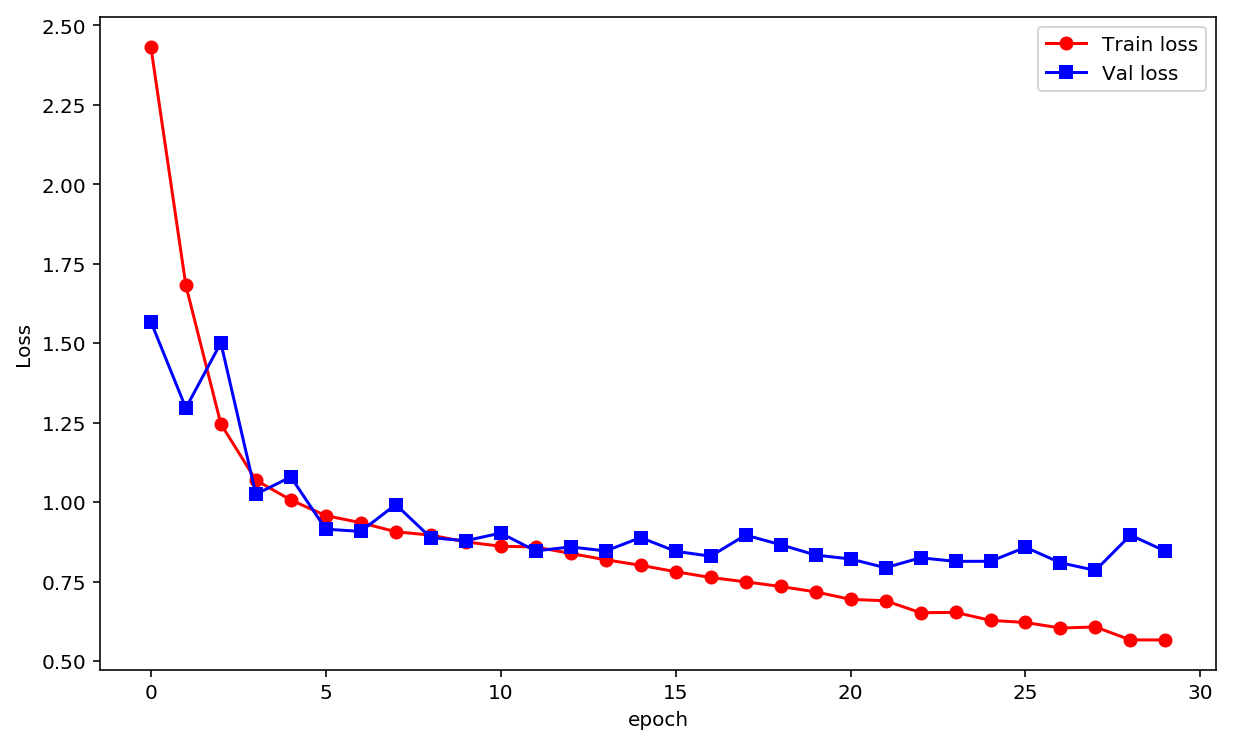

In [21]:
## 可视化模型训练过程中
plt.figure(figsize=(10,6))
plt.plot(train_process.epoch,train_process.train_loss_all,
         "ro-",label = "Train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,
         "bs-",label = "Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

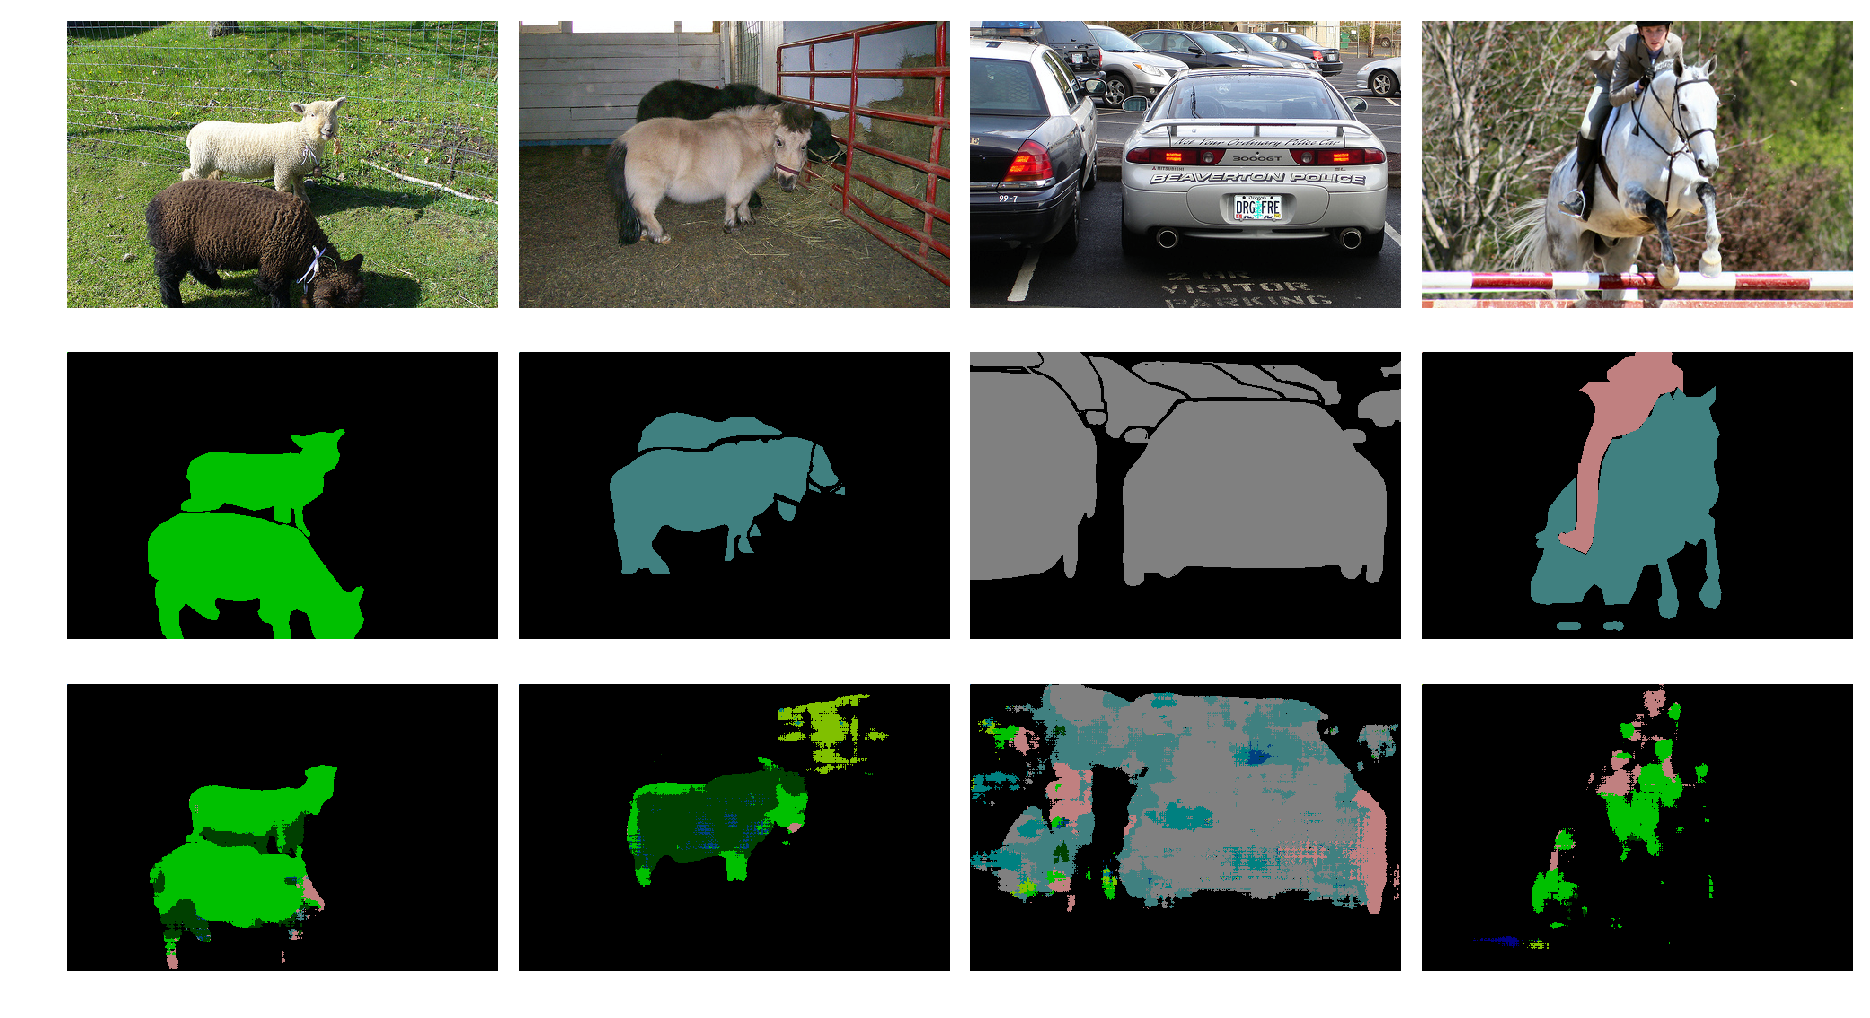

In [22]:
##  从验证集中获取一个batch的数据
for step, (b_x, b_y) in enumerate(val_loader):  
    if step > 0:
        break
## 对验证集中一个batch的数据进行预测，并可视化预测效果
fcn8s.eval()
b_x  =b_x.float().to(device)
b_y  =b_y.long().to(device)
out = fcn8s(b_x)
out = F.log_softmax(out,dim=1)
pre_lab = torch.argmax(out,1)
## 可视化一个batch的图像，检查数据预处理 是否正确
b_x_numpy = b_x.cpu().data.numpy()
b_x_numpy = b_x_numpy.transpose(0,2,3,1)
b_y_numpy = b_y.cpu().data.numpy()
pre_lab_numpy = pre_lab.cpu().data.numpy()
plt.figure(figsize=(16,9))
for ii in range(4):
    plt.subplot(3,4,ii+1)
    plt.imshow(inv_normalize_image(b_x_numpy[ii]))
    plt.axis("off")
    plt.subplot(3,4,ii+5)
    plt.imshow(label2image(b_y_numpy[ii],colormap))
    plt.axis("off")
    plt.subplot(3,4,ii+9)
    plt.imshow(label2image(pre_lab_numpy[ii],colormap))
    plt.axis("off")
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
